In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   102M      0  0:00:07  0:00:07 --:--:--  103M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip

In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [5]:
DATA_DIR = '/kaggle/working/PetImages'

data_dir_dogs = os.path.join(DATA_DIR, 'Dog')
data_dir_cats = os.path.join(DATA_DIR, 'Cat')

print(f'There are {len(os.listdir(data_dir_dogs))} images of dogs')
print(f'There are {len(os.listdir(data_dir_cats))} images of cats')

There are 11670 images of dogs
There are 11742 images of cats


In [6]:
def train_val_datasets():
    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(150,150),
        batch_size=(128),
        color_mode='rgb',
        label_mode='binary',
        validation_split=0.20,
        subset='both',
        seed=42
    )
    return training_dataset, validation_dataset

In [7]:
training_dataset, validation_dataset = train_val_datasets()

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [8]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
        tf.keras.layers.RandomZoom(0.2, fill_mode='nearest')
    ])
    return augmentation_model

In [9]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    return model

In [10]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs=None):
        if logs['accuracy'] >= 0.9 and logs['val_accuracy'] >= 0.9:
            self.model.stop_training = True
            print('\nReached 90% train accuracy and 90% validation accuracy. Canceling the train')

In [11]:
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    training_dataset,
    epochs=15,
    validation_data = validation_dataset,
    callbacks = [EarlyStoppingCallback()]
)

Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - accuracy: 0.5312 - loss: 0.8171 - val_accuracy: 0.6378 - val_loss: 0.6126
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.6679 - loss: 0.6047 - val_accuracy: 0.7409 - val_loss: 0.5119
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.7249 - loss: 0.5344 - val_accuracy: 0.7569 - val_loss: 0.4916
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.7525 - loss: 0.4979 - val_accuracy: 0.7591 - val_loss: 0.4776
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.7861 - loss: 0.4431 - val_accuracy: 0.7561 - val_loss: 0.5023
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8026 - loss: 0.4189 - val_accuracy: 0.7625 - val_loss: 0.5030
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.8319 - loss: 0.3676 - val_accuracy: 0.7933 - val_loss: 0.4363
Epoch 8/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.8469 - loss: 0.3323 -

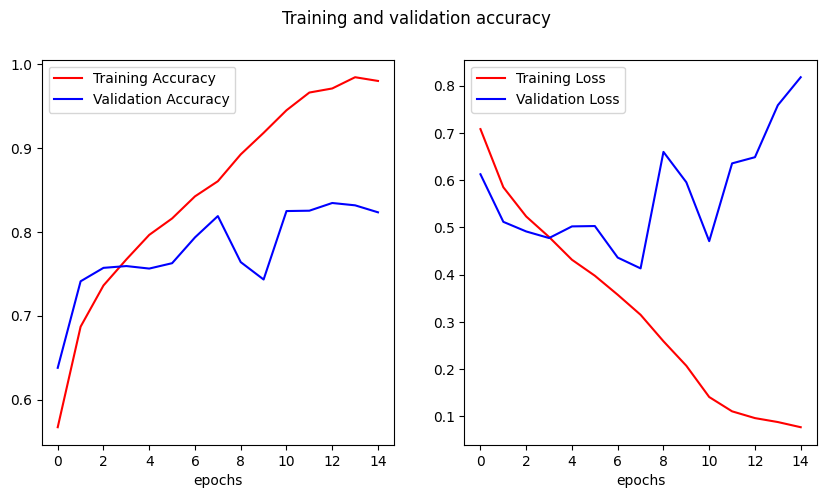

In [13]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [14]:
model_with_augmentation = tf.keras.Sequential([
    create_augmentation_model(),
    create_model()
])

model_with_augmentation.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
history = model_with_augmentation.fit(
    training_dataset,
    epochs=50,
    validation_data = validation_dataset,
    callbacks = [EarlyStoppingCallback()]
)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.5157 - loss: 0.7966 - val_accuracy: 0.5745 - val_loss: 0.6514
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.6010 - loss: 0.6660 - val_accuracy: 0.6534 - val_loss: 0.6091
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.6351 - loss: 0.6347 - val_accuracy: 0.7078 - val_loss: 0.5710
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.6621 - loss: 0.6138 - val_accuracy: 0.6807 - val_loss: 0.5891
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.6658 - loss: 0.6112 - val_accuracy: 0.7281 - val_loss: 0.5531
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6843 - loss: 0.5887 - val_accuracy: 0.6497 - val_loss: 0.6018
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.6960 - loss: 0.5773 - val_accuracy: 0.5848 - val_loss: 0.6661
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.6953 - loss: 0

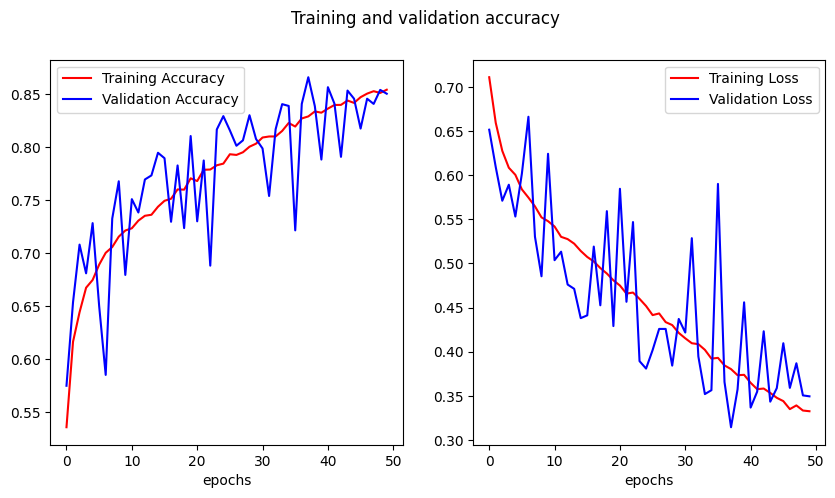

In [16]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()